In [1]:
!jupyter nbconvert --to python seqInit.ipynb

[NbConvertApp] Converting notebook seqInit.ipynb to python
[NbConvertApp] Writing 1367 bytes to seqInit.py


---
### 标准RNN模型

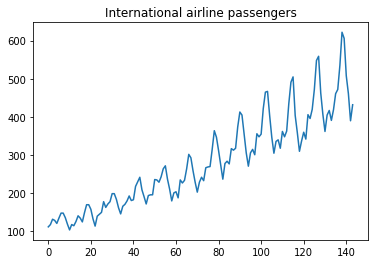

dataSet shape :	 (144, 1)
train data shape : (120, 1)
real data shape : (144, 1)


In [2]:
# 引入torch相关模块
import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import init

# 引入初始化文件中的相关内容
from seqInit import toTs, cudAvl
from seqInit import input_size
from seqInit import train, real

# 引入画图工具
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# 定义RNN模型

class rnnModel(nn.Module) :
    def __init__(self, in_dim, hidden_dim, out_dim, layer_num) :
        super().__init__()
        self.rnnLayer = nn.RNN(in_dim, hidden_dim, layer_num)
        self.fcLayer = nn.Linear(hidden_dim, out_dim)
        optim_range = np.sqrt(1.0 / hidden_dim)
        self.weightInit(optim_range)
        
    def forward(self, x) :
        out, _ = self.rnnLayer(x)
        out = out[12:]
        out = self.fcLayer(out)
        return out

    def weightInit(self, gain=1):
        # 使用初始化模型参数
        for name, param in self.named_parameters() :
            if 'rnnLayer.weight' in name :
                init.orthogonal(param, gain)
    
# 输入维度为1，输出维度为1，隐藏层维数为10, 定义rnn层数为2
rnn = cudAvl(rnnModel(1, 10, 1, 2))

# 确定损失函数和优化函数
criterion = nn.MSELoss()
optimizer = optim.Adam(rnn.parameters(), lr = 1e-2)

In [4]:
# 处理输入

def create_dataset(dataset) :
    data = dataset.reshape(-1, 1, 1)
    return torch.from_numpy(data)

trainX = create_dataset(train[:-1])
trainY = create_dataset(train[1:])[12:]
print(trainX.shape, trainY.shape)

torch.Size([119, 1, 1]) torch.Size([107, 1, 1])


Epoch[200/2000], loss = 0.00214
Epoch[400/2000], loss = 0.00219
Epoch[600/2000], loss = 0.00173
Epoch[800/2000], loss = 0.00077
Epoch[1000/2000], loss = 0.00026
Epoch[1200/2000], loss = 0.00033
Epoch[1400/2000], loss = 0.00013
Epoch[1600/2000], loss = 0.00012
Epoch[1800/2000], loss = 0.00013
Epoch[2000/2000], loss = 0.00011


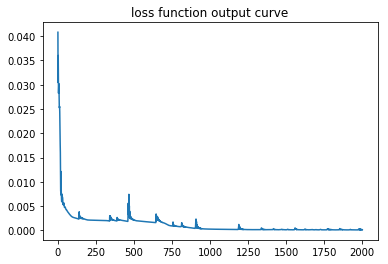

CPU times: user 1min 29s, sys: 20 s, total: 1min 49s
Wall time: 1min 53s


In [5]:
%%time

# 训练RNN模型
frq, sec = 2000, 200
loss_set = []
for e in range(1, frq + 1) :
    inputs = cudAvl(Variable(trainX))
    target = cudAvl(Variable(trainY))
    # forward
    output = rnn(inputs)
    loss = criterion(output, target)
    # update gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # print training information
    print_loss = loss.data[0]
    loss_set.append((e, print_loss))
    if e % sec == 0 :
        print('Epoch[{}/{}], loss = {:.5f}'.format(e, frq, print_loss))

# 作损失函数图像
pltX = np.array([loss[0] for loss in loss_set])
pltY = np.array([loss[1] for loss in loss_set])
plt.title('loss function output curve')
plt.plot(pltX, pltY)
plt.show()

torch.Size([143, 1, 1]) (131,) (143,)


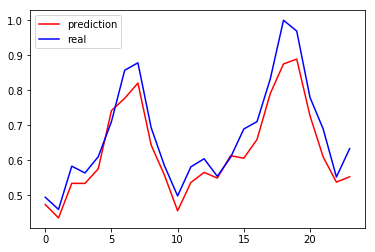

In [6]:
# 测试

rnn = rnn.eval()
px = real[:-1].reshape(-1, 1, 1)
px = torch.from_numpy(px)
ry = real[1:].reshape(-1)
varX = cudAvl(Variable(px, volatile=True))
py = rnn(varX).data
py = np.array(py).reshape(-1)
print(px.shape, py.shape, ry.shape)

# 画出实际结果和预测的结果
plt.plot(py[-24:], 'r', label='prediction')
plt.plot(ry[-24:], 'b', label='real')
plt.legend(loc='best')